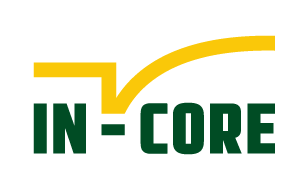


# EPN Network Analysis

**Jupyter Notebook Created by**:
   - Mehrzad Rahimi, Postdoctoral fellow at Rice University (mr77@rice.edu)
   - Jamie E. Padgett, Professor at Rice University (jamie.padgett@rice.edu)

## 1) Initialization

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import geopandas as gpd 
import numpy as np
import sys 
import os 
import glob
import matplotlib.pyplot as plt
import contextily as ctx
import copy
import math
from scipy.stats import norm
from pathlib import Path
import networkx as nx

from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore_viz.geoutil import GeoUtil as geoviz
from pyincore_viz.plotutil import PlotUtil as plotviz

# importing pyIncone analyses:
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.bridgedamage import BridgeDamage
from pyincore.analyses.roaddamage import RoadDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential

In [2]:
# Check package versions - good practice for replication
print("Python Version ", sys.version)
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)

Python Version  3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:41:22) [MSC v.1929 64 bit (AMD64)]
pandas version:  1.5.2
numpy version:  1.24.1


In [3]:
# Check working directory - good practice for relative path access
os.getcwd()

'C:\\Users\\ka50\\Box\\Rice\\Software_Projects\\Pycharm\\IN-CORE_Galveston\\jupyter_book\\notebooks\\02_Damage_EPNAnalysis'

In [4]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_service = FragilityService(client)

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

## 2) Setting up an alternative plotting function to plot spatially

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_gdf_map(gdf, column, category=False, basemap=True, source=ctx.providers.OpenStreetMap.Mapnik, **kwargs):
    """
    Taken from pyincore-viz. 
    Not using the pyincore-viz version b/c it's limited on plotting options
        - Added **kwargs for more control over the geopandas plotting function
    """
    fig, ax = plt.subplots(1,1, figsize=(10,15))
    gdf = gdf.to_crs(epsg=3857)

    if category == False: # adding a colorbar to side
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)

        ax = gdf.plot(figsize=(10, 10), 
                      column=column,
                      categorical=category, 
                      legend=True,
                      ax=ax,
                      cax=cax,
                     **kwargs)

    elif category == True:
        ax = gdf.plot(figsize=(10, 10), 
                      column=column,
                      categorical=category, 
                      legend=True,
                      ax=ax,
                     **kwargs)

        
    if basemap:
        ctx.add_basemap(ax, source=source)

import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

## 3) Failure probabilities for specific hazard scenario

### What is the your desired hurricane simulation?

In [18]:
hur_no = int(input('The No. of your desired hurricane simulation: '))

In [19]:
woodpole_dict        =  {1: "Galv_EPN_woodpoles_result_hurNo1.csv", 
                         2: "Galv_EPN_woodpoles_result_hurNo2.csv",
                         3: "Galv_EPN_woodpoles_result_hurNo3.csv",
                         4: "Galv_EPN_woodpoles_result_hurNo4.csv",}

prestressedpole_dict =  {1: "Galv_EPN_prestressedpoles_result_hurNo1.csv", 
                         2: "Galv_EPN_prestressedpoles_result_hurNo2.csv",
                         3: "Galv_EPN_prestressedpoles_result_hurNo3.csv",
                         4: "Galv_EPN_prestressedpoles_result_hurNo4.csv",}

pole_dict =             {1: "Galv_EPN_poles_result_hurNo1.csv", 
                         2: "Galv_EPN_poles_result_hurNo2.csv",
                         3: "Galv_EPN_poles_result_hurNo3.csv",
                         4: "Galv_EPN_poles_result_hurNo4.csv",}

tower_dict           =  {1: "Galv_EPN_towers_result_hurNo1.csv", 
                         2: "Galv_EPN_towers_result_hurNo2.csv",
                         3: "Galv_EPN_towers_result_hurNo3.csv",
                         4: "Galv_EPN_towers_result_hurNo4.csv",}

substation_dict      =  {1: "Galv_EPN_substations_result_hurNo1.csv", 
                         2: "Galv_EPN_substations_result_hurNo2.csv",
                         3: "Galv_EPN_substations_result_hurNo3.csv",
                         4: "Galv_EPN_substations_result_hurNo4.csv",}

In [20]:
WoodPoleDamage_csv        = woodpole_dict[hur_no]
PrestressedPoleDamage_csv = prestressedpole_dict[hur_no]
PoleDamage_csv            = pole_dict[hur_no]
TowerDamage_csv           = tower_dict[hur_no]
SubstationDamage_csv      = substation_dict[hur_no]

In [21]:
path_to_output = os.path.join(os.getcwd(), 'output', 'Results for Hurricane No{}' .format(hur_no))
if not os.path.exists(path_to_output):
    os.makedirs(path_to_output)

# 4) Network Analysis using NetworkX

## Importing damage data

In [22]:
WoodPoleDamage_df        = pd.read_csv(WoodPoleDamage_csv)
PrestressedPoleDamage_df = pd.read_csv(PrestressedPoleDamage_csv)
PoleDamage_df            = pd.read_csv(PoleDamage_csv)
TowerDamage_df           = pd.read_csv(TowerDamage_csv)
SubstationDamage_df      = pd.read_csv(SubstationDamage_csv)

## Importing network data

In [23]:
Galv_TransmissionNetwork_df = pd.read_csv('Galv_TransmissionNetwork.csv')
Galv_DistributionNetwork_df = pd.read_csv('Galv_DistributionNetwork.csv')
Galv_UndergroundNetwork_df  = pd.read_csv('Galv_UndergroundNetwork.csv')

In [24]:
Galv_DistributionUndergroundNetwork_df = pd.concat([Galv_DistributionNetwork_df, Galv_UndergroundNetwork_df], ignore_index=True)

## Creating adjacency matrix for distribution-underground network

In [25]:
Galv_DistributionUndergroundNetwork_df

,Start Node,End Node
0,6,11134
1,12013,2682
2,2682,2683
3,2682,12014
4,11134,11133
...,...,...
15508,9857,9871
15509,9856,9870
15510,9795,9790
15511,768,11166


In [26]:
start_node_DU = Galv_DistributionUndergroundNetwork_df[['Start Node']].to_numpy()
end_node_DU = Galv_DistributionUndergroundNetwork_df[['End Node']].to_numpy()

Size_Adj_DU=int(max(max(start_node_DU),max(end_node_DU )))
Adj_DU=np.zeros([Size_Adj_DU+1,Size_Adj_DU+1])
Size_Adj_DU

for i in range(0, np.size(start_node_DU,0)):
    k=start_node_DU[i,0]
    j=end_node_DU[i,0]
    Adj_DU[k,j]=int(Adj_DU[k,j]+1.0);
    Adj_DU[j,k]=Adj_DU[k,j];
np.size(Adj_DU,0)
Adj_DU[6,11134]
print(sum(sum(Adj_DU)))

31026.0


## Creating adjacency matrix for transportation network

In [27]:
Galv_TransmissionNetwork_df

,Start Node,End Node
0,5801,4333
1,4333,14534
2,14534,14535
3,14535,14536
4,14536,4302
...,...,...
1098,12350,12349
1099,12349,12348
1100,12348,12347
1101,12347,12346


In [28]:
start_node_T = Galv_TransmissionNetwork_df[['Start Node']].to_numpy()
end_node_T = Galv_TransmissionNetwork_df[['End Node']].to_numpy()

Size_Adj_T=int(max(max(start_node_T),max(end_node_T )))
Adj_T=np.zeros([Size_Adj_T+1,Size_Adj_T+1])
Size_Adj_T

for i in range(0, np.size(start_node_T,0)):
    k=start_node_T[i,0]
    j=end_node_T[i,0]
    Adj_T[k,j]=int(Adj_T[k,j]+1.0);
    Adj_T[j,k]=Adj_T[k,j];
np.size(Adj_T,0)
Adj_T[5801,4333]
print(sum(sum(Adj_T)))

2206.0


## Poles-Buildings matching

In [18]:
# reading file
closest_poles_to_bldgs_df = pd.read_csv('closest_poles_to_bldgs.csv')


In [19]:
closest_poles_to_bldgs_df 

,Unnamed: 0,guid,geometry_x,OBJECTID,LON,LAT,CLASS,HEIGHT,TYPE,SpanLength,geometry_y,distance
0,0,b39dd67f-802e-402b-b7d5-51c4bbed3464,POINT (-94.92101 29.22867),81,-94.920949,29.227509,5.0,20.0,1,44.339908,POINT (-94.92094918 29.22750947),12.972083
1,1,e7467617-6844-437e-a938-7300418facb8,POINT (-94.92075 29.22871),83,-94.920726,29.227814,5.0,20.0,1,12.173564,POINT (-94.92072633 29.22781376),8.944374
2,2,d7ce12df-660d-42fc-9786-f0f543c00002,POINT (-94.92106 29.22799),93,-94.921127,29.228522,5.0,20.0,1,31.155735,POINT (-94.92112712 29.22852154),9.022716
3,3,74aac543-8aae-4779-addf-754e307a772b,POINT (-94.92139 29.228),80,-94.921431,29.227216,5.0,20.0,1,65.903857,POINT (-94.92143125 29.22721624),8.771394
4,4,ed3147d3-b7b8-49da-96a9-ddedfccae60c,POINT (-94.92146 29.22749),80,-94.921431,29.227216,5.0,20.0,1,65.903857,POINT (-94.92143125 29.22721624),4.127933
...,...,...,...,...,...,...,...,...,...,...,...,...
18957,18957,b33b8857-892e-42bb-93c9-4a025fc59d69,POINT (-94.92316 29.22811),115,-94.923173,29.228940,5.0,20.0,1,59.423983,POINT (-94.92317324 29.22893958),8.052183
18958,18958,902f2d0e-5676-4a9d-9873-168dea6b6224,POINT (-94.92289 29.2282),94,-94.923030,29.228031,5.0,20.0,1,76.323221,POINT (-94.92303018 29.22803088),15.670623
18959,18959,6e1cb252-d668-408b-95a5-c00707ed533b,POINT (-94.92259 29.22832),114,-94.922666,29.229132,5.0,20.0,1,79.698817,POINT (-94.92266605 29.2291315),11.465839
18960,18960,d0a45723-a0a3-4be2-87cb-373c7fdc363f,POINT (-94.92233 29.22841),76,-94.922322,29.226667,5.0,20.0,1,27.425693,POINT (-94.92232193 29.22666654),16.658708


## Population dislocation results

In [20]:
# reading file
Galv_pop_disl_results_df = pd.read_csv('galveston-pop-disl-results_hurNo' + str(hur_no) + '.csv')

## Housing recovery results

In [21]:
# reading file
housing_recovery_result_df = pd.read_csv('housing_recovery_result_hurNo' + str(hur_no) + '.csv')

In [22]:
housing_recovery_result_df

,guid,huid,Zone,SV,1,2,3,4,5,6,...,81,82,83,84,85,86,87,88,89,90
0,eca98323-d57f-4691-a340-b4e0e19c2346,B481677240001040H002,Z2,0.349,1.0,3.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,eca98323-d57f-4691-a340-b4e0e19c2346,B481677240001040H005,Z4,0.814,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2,eca98323-d57f-4691-a340-b4e0e19c2346,B481677240001040H001,Z2,0.209,1.0,3.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,eca98323-d57f-4691-a340-b4e0e19c2346,B481677240001040H003,Z1,0.122,1.0,3.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,eca98323-d57f-4691-a340-b4e0e19c2346,B481677240001040H004,Z1,0.801,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20174,26c45ad6-7adf-4e49-b3d0-f8d38dbad8e0,B481677261002143H003,Z2,0.272,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
20175,7f4ab709-2946-4dbf-9e7f-54c09fb98044,B481677261002143H001,Z3,0.575,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
20176,58cde862-e040-4caa-88d3-143d61b2449c,B481677261002143H004,Z1,0.141,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
20177,dcc061cc-945e-42d6-be7b-3860df489049,B481677261002143H006,Z5,0.859,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [82]:
hhr_guid = housing_recovery_result_df[["guid"]].to_numpy()
hhr_huid = housing_recovery_result_df[["huid"]].to_numpy()
cpoletbldg_guid = closest_poles_to_bldgs_df[["guid"]].to_numpy()
cpoletbldg_OBJECTID = closest_poles_to_bldgs_df[["OBJECTID"]].to_numpy()
PoleDamage_df_PF = PoleDamage_df[["Pf_Pole_M"]].to_numpy()
PoleDamage_df_OBJECTID = PoleDamage_df[["OBJECTID"]].to_numpy()
polegeometry = closest_poles_to_bldgs_df[["geometry_y"]].to_numpy()
pole_to_bldg_dis= closest_poles_to_bldgs_df[["distance"]].to_numpy()

In [107]:
xxx = np.zeros(np.size(hhr_huid))
for i in range(0, np.size(hhr_huid)-1):
    cpoletbldg_guid_index = np.where(cpoletbldg_guid == hhr_guid[i])
    cpoletbldg_OBJECTID[cpoletbldg_guid_index[0]]
    PoleDamage_df_PF_index = np.where(PoleDamage_df_OBJECTID == cpoletbldg_OBJECTID[cpoletbldg_guid_index[0]])
    xxx[i] = PoleDamage_df_PF[PoleDamage_df_PF_index[0]]


In [109]:
len(xxx)

20179

In [110]:
PF_close_pole_df = pd.DataFrame({'Pf_Pole':xxx})

In [112]:
hhr_Polefailure_df = pd.merge(housing_recovery_result_df, PF_close_pole_df , left_index=True, right_index=True)
hhr_Polefailure_df 

,guid,huid,Zone,SV,1,2,3,4,5,6,...,82,83,84,85,86,87,88,89,90,Pf_Pole
0,eca98323-d57f-4691-a340-b4e0e19c2346,B481677240001040H002,Z2,0.349,1.0,3.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.129169
1,eca98323-d57f-4691-a340-b4e0e19c2346,B481677240001040H005,Z4,0.814,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.129169
2,eca98323-d57f-4691-a340-b4e0e19c2346,B481677240001040H001,Z2,0.209,1.0,3.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.129169
3,eca98323-d57f-4691-a340-b4e0e19c2346,B481677240001040H003,Z1,0.122,1.0,3.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.129169
4,eca98323-d57f-4691-a340-b4e0e19c2346,B481677240001040H004,Z1,0.801,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.129169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20174,26c45ad6-7adf-4e49-b3d0-f8d38dbad8e0,B481677261002143H003,Z2,0.272,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.036008
20175,7f4ab709-2946-4dbf-9e7f-54c09fb98044,B481677261002143H001,Z3,0.575,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.015908
20176,58cde862-e040-4caa-88d3-143d61b2449c,B481677261002143H004,Z1,0.141,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.021527
20177,dcc061cc-945e-42d6-be7b-3860df489049,B481677261002143H006,Z5,0.859,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.017917
